# Analyze Data

## Summarize Data

Formal Description
1. Finding a correlation between horizontal distance drilled and the amount of oil recovered
2. For both horizontal and vertical types of wells
3. Resample by end date year and compare results to see if production has increased over time with the assumption of better technologies and processes

Assumptions
1. Cost increases per linear foot drilled
2. Recovery per foot decreases as over a number of feet increases
3. More risk with drilling horizontally; however it is a lot better than drilling new holes every time
4. Geographic clustering of drilling data could lead us to different projections
5. Higher proppant PPF/frac fluid theoretically leads to more recovery.  Not an assumption - higher costs as proppant PPF goes up.

# Data Dictionary:
## Dimensions/Categorical:
1. API:  American Petroleum Identification Code (10 digits) -- check for duplicates (switch to 14 digits if necessary)
5. Entity Reserve Category:  (IGNORE: unless we get into probability)
    - Developed Producing --
    - Undeveloped --
    - (Blanks) -- 
13. First Prod:  first production date, drop before 1940
6. Formation: 
    - Name of the layer of rock
    - Group by Formation: From one formation to the next, the rock properties are different, can be imputed from vertical depth if necessary
9. Frac Fluid GPF:  another key driver, a continuous variable, how much water is forced into the hold to frack it. Drives up cost.   
14. Last Prod:  last production date, drop before 1940
4. MajorPhase:  What is the predominant thing it produces
    - Gas
    - Inj -- Injection (ignore)
    - Oil
    - Other -- Do Not Know; wells that are plugged; Shut-in that no longer produce there might be some exceptions -- KEEP
    - SWD --  Salt Water Disposal (ignore)
7. Prod Method:  What type of surface machine is used at that well, probably won’t use this feature. May use for anomalies. 
    - Flowing --
    - Gas lift --
    - Jetted --
    - Other --
    - Plunger Lift -- 
    - Pumping --
    - Swabbing -- 
    - Undesignated -- 
    - Unknown --
3. Status:
    - Active -- producing and have ultimate recovery number
    - Drilling -- actively being drilled, likely no recovery numbers 
    - Drilled Un-completed -- drilled and hooked up, but not yet on production, no recovery number, also referred to as a “DUC”, we will say it’s same as Active
    - DryHole -- nothing in the hole
    - Inactive -- same as Shut-in
    - Injection -- we will exclude these, used for disposal water, etc.
    - Other -- do not know
    - P&A -- plugged and abandoned, know how much it previously produced
    - Permitted -- the state has approved to drill, if has first and the last production, it’s active and the state hasn’t re-filed it, yet
    - Shut-in -- also turned off, but not plugged with concrete, know how much it previously produced
    - Uncompleted -- drilled, but have not yet hooked it up
2. Type:  Vertical, Horizontal, or “Other” -- other will be imputed from the lateral length
25. Well Id:  

***********
## Measures/Continuous:
12. Frac Fluid Type:  classifier, may or may not be a driver   
    - Acid
    - Foam
    - Freshwater
    - GelXLink
    - None
    - Oil
    - Other
    - Saltwater
    - Slickwater
    - (Blanks) -- mean it’s unknown, but they used something
11. Frac Stages:   number of stages of fracking, may not use, mostly null, a direct correlation between profit and frac stages, each stage drives up the cost
16. Gas EUR:  estimated ultimate recovery of gas, gas measured in mcf (6 mcf fits in one oil barrel), may want to combine Oil EUR and Gas EUR 
20. GOR Hist: the ratio of gas to oil produced to date by well, changes every month
21. IP90 BOEQPD: a metric that might come in handy, initially garbage comes out and then good oil, so this gives average oil recovered over 90 days, “initial potential 90-day barrel of oil equivalent (oil and gas) per day”
10. Lateral Len:  length of perforations (to let oil into the pipe)
26. MidPoint Lat:  midpoint surface latitude
27. MidPoint Long:  midpoint surface longitude
15. Oil EUR:  estimated ultimate recovery of oil, what we want to predict, oil in barrels
17. Oil Gravity:  likely a driver, may have to impute, the thickness of the oil, viscosity, usually related to gas/oil ratio (GOR Hist), could be imputed from GOR Hist.
19. Oil Hist: the number of barrels produced to date by well
8. Proppant PPF:  after injecting water for fracking, sand or ceramic is injected to hold open the layers of formation, to “prop” open the layers. Measured in pound per foot. A continuous variable that will be a key driver. Drives up cost.
18. Qi (init):  peak rate (like for a time series) at the start, initial producing rate
22. Sur Lat:  surface latitude 
23. Sur Long:  surface longitude  

In [1]:
import pandas as pd
from acquire_prepare import acquire_oil
from acquire_prepare import prep_data

In [2]:
df = acquire_oil()
df = prep_data(df)
df.shape

(16250, 31)

### Data Structure

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16250 entries, 0 to 19495
Data columns (total 31 columns):
api14                 16250 non-null int64
type                  16250 non-null category
status                16250 non-null category
major_phase           16250 non-null category
formation             16229 non-null object
proppant_ppf          12018 non-null float64
prod_method           16250 non-null category
frac_fluid_gpf        14133 non-null float64
lateral_len           16250 non-null float64
frac_stages           15056 non-null float64
frac_fluid_type       16066 non-null category
first_prod            16250 non-null datetime64[ns]
last_prod             16250 non-null datetime64[ns]
oil_gravity           15817 non-null float64
peak_boepd            16250 non-null float64
oil_hist              16250 non-null float64
gas_hist              16250 non-null float64
gor_hist              15597 non-null float64
ip90_boeqpd           16250 non-null float64
landing_depth         160

In [4]:
df.sample(10)

,api14,type,status,major_phase,formation,proppant_ppf,prod_method,frac_fluid_gpf,lateral_len,frac_stages,...,sur_long,well_id,mid_point_lat,mid_point_long,recovery,recovery_per_foot,months_active,recovery_per_month,lateral_class,vintage
5119,42227343670000,Vertical,Inactive,OIL,SAN ANDRES D,153.677277,Pumping,107.448959,911.0,0.0,...,-101.324331,156356,32.103839,-101.324331,5.500000,6.037322,63,87.301587,one,2011
2771,42173320090000,Vertical,Inactive,OIL,SAN ANDRES,NaN,Pumping,8.928572,336.0,0.0,...,-101.456626,153608,32.081049,-101.456626,3.408000,10.142857,19,179.368421,one,2003
2647,42173102170000,Vertical,Inactive,OIL,SAN ANDRES D,NaN,Pumping,34.090908,44.0,0.0,...,-101.482301,156429,32.072096,-101.482301,2.611000,59.340909,13,200.846154,one,2012
10650,42329406650000,Horizontal,Active,OIL,WOLFCAMP,1487.992430,Gas Lift,2100.101000,8453.0,0.0,...,-102.097195,146456,31.679324,-102.100121,161.953675,19.159313,34,4763.343373,nine,2016
2786,42173321430000,Vertical,Inactive,OIL,DEAN,NaN,Pumping,23.000000,167.0,NaN,...,-101.701080,94206,31.655200,-101.701080,104.511167,625.815369,164,637.263211,one,1977
6783,42301317910000,Horizontal,Inactive,OIL,BONE SPRING,848.028400,Pumping,971.898254,3872.0,16.0,...,-103.741572,147625,31.978337,-103.741087,228.358011,58.976759,56,4077.821622,four,2013
468,42003459350000,Horizontal,Active,OIL,DEVONIAN,696.085300,Pumping,624.395300,3597.0,0.0,...,-102.606026,143223,32.141104,-102.607578,409.927233,113.963646,55,7453.222424,four,2014
8868,42329341010000,Vertical,Inactive,OIL,SPRABERRY,657.797600,Pumping,458.928558,168.0,0.0,...,-101.817249,157203,31.934483,-101.817249,19.864167,118.239087,206,96.427994,one,1999
14890,42383395210000,Horizontal,Inactive,OIL,WOLFCAMP,1895.325440,Gas Lift,1491.855350,4471.0,0.0,...,-101.288194,99942,31.225874,-101.286924,50.378000,11.267725,6,8396.333333,five,2015
18178,42461404100000,Horizontal,Inactive,OIL,WOLFCAMP,2188.000000,Gas Lift,2581.000000,10360.0,1.0,...,-102.071681,100161,31.425131,-102.075820,142.959833,13.799212,1,142959.833333,eleven,2017


### Data Distributions

In [5]:
print (df.apply(lambda x: x.nunique()))

api14                 16033
type                      2
status                    2
major_phase               3
formation               179
proppant_ppf          11670
prod_method               9
frac_fluid_gpf        13297
lateral_len            6827
frac_stages              65
frac_fluid_type          10
first_prod              622
last_prod               438
oil_gravity             245
peak_boepd            14894
oil_hist              15395
gas_hist              15203
gor_hist              15589
ip90_boeqpd           15633
landing_depth          5984
sur_lat               15560
sur_long              15764
well_id               16250
mid_point_lat         15900
mid_point_long        15913
recovery              16182
recovery_per_foot     16237
months_active           565
recovery_per_month    16088
lateral_class            14
vintage                  63
dtype: int64


In [6]:
df.describe()

,api14,proppant_ppf,frac_fluid_gpf,lateral_len,frac_stages,oil_gravity,peak_boepd,oil_hist,gas_hist,gor_hist,...,sur_lat,sur_long,well_id,mid_point_lat,mid_point_long,recovery,recovery_per_foot,months_active,recovery_per_month,vintage
count,1.625000e+04,1.201800e+04,1.413300e+04,16250.000000,15056.000000,15817.000000,16250.000000,16250.000000,16250.000000,1.559700e+04,...,16250.000000,16250.000000,16250.000000,16250.000000,16250.000000,16250.000000,16250.000000,16250.000000,1.625000e+04,16250.000000
mean,4.220174e+13,2.409546e+03,2.118496e+03,4170.744677,2.173618,3.412634,429.991144,122.782936,454.575591,4.589510e+06,...,31.724644,-102.157757,140956.327877,31.724889,-102.157851,190.474018,431.389005,89.301600,inf,2007.973292
std,1.110139e+12,7.513996e+04,6.832595e+04,3108.757709,7.677189,12.667286,470.398824,179.474173,1319.099721,4.867718e+08,...,0.536802,0.827376,19152.058603,0.536721,0.827368,345.909094,5313.508554,102.959469,NaN,11.022779
min,3.000521e+13,2.531144e-01,0.000000e+00,1.000000,0.000000,0.000000,0.065754,0.000000,0.000000,0.000000e+00,...,30.233049,-104.533822,22866.000000,30.232985,-104.532366,0.000000,0.000000,0.000000,0.000000e+00,1955.000000
25%,4.222701e+13,3.355705e+02,1.366258e+02,1510.250000,0.000000,0.000000,59.992110,20.400750,50.121000,1.367160e+03,...,31.380880,-102.660748,142531.250000,31.382211,-102.659731,33.157084,14.667256,33.000000,4.380776e+02,2004.000000
50%,4.232934e+13,1.048781e+03,7.459227e+02,4051.000000,0.000000,0.000000,285.733067,76.838500,218.868500,2.477042e+03,...,31.675202,-101.947623,147348.500000,31.676249,-101.948102,107.657090,27.559452,55.000000,1.827793e+03,2013.000000
75%,4.238339e+13,1.509654e+03,1.495726e+03,7001.500000,0.000000,0.000000,660.607700,167.861750,529.526250,5.370206e+03,...,31.986593,-101.530365,152325.750000,31.991514,-101.531618,204.984171,63.993360,92.000000,4.239073e+03,2015.000000
max,4.250137e+13,7.646000e+06,7.497903e+06,13815.000000,70.000000,72.700000,9358.215000,3846.625000,80091.790000,6.044117e+10,...,33.834820,-100.399997,157521.000000,33.836550,-100.399927,13345.776667,467575.734583,747.000000,inf,2018.000000


In [8]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import numpy as np
import pandas as pd

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import plotly.plotly as py
import plotly.tools as tls
import cufflinks as cf
print('cufflinks version ', cf.__version__)
import plotly.graph_objs as go
import sys # used in command to make entire array print by default

# Modeling
from scipy.spatial.distance import cdist
from scipy.cluster.vq import kmeans2, whiten
from sklearn.cluster import KMeans
from sklearn import metrics
import math
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from scipy import stats
from scipy.stats import ttest_ind
from pandas.tools.plotting import scatter_matrix
from matplotlib.ticker import FormatStrFormatter


# Though the following import is not directly being used, it is required
# for 3D projection to work
from mpl_toolkits.mplot3d import Axes3D
pd.options.display.float_format = '{:20,.2f}'.format


# ignore warnings
import warnings
warnings.filterwarnings("ignore")

cufflinks version  0.15


In [9]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [10]:
# makes entire array print by default, can add [:##] to end to set length
np.set_printoptions(threshold=sys.maxsize)

In [12]:
len(df.columns) # 31 features

31

## Visualize Data

In [24]:
xgb_df = df.select_dtypes('number')
xgb_df.drop(columns='oil_hist', inplace=True)
xgb_df.sample(3)

,api14,proppant_ppf,frac_fluid_gpf,lateral_len,frac_stages,oil_gravity,peak_boepd,gas_hist,gor_hist,ip90_boeqpd,...,sur_lat,sur_long,well_id,mid_point_lat,mid_point_long,recovery,recovery_per_foot,months_active,recovery_per_month,vintage
6730,42301317020200,648.71,350.93,"3,786.00",0.00,0.00,468.19,303.21,"1,661.31",380.70,...,31.72,-103.52,146227,31.72,-103.51,202.75,53.55,78,"2,599.31",2012
1423,42105416730000,"1,040.09","1,053.05","7,782.00",30.00,0.00,157.66,469.49,"9,073.11",149.21,...,31.02,-101.24,142909,31.03,-101.24,105.11,13.51,66,"1,592.63",2013
16426,42389351480000,"1,758.41","2,010.23","7,550.00",38.00,0.00,905.32,705.30,"3,135.88",745.31,...,31.39,-103.38,152030,31.38,-103.39,187.94,24.89,33,"5,695.13",2016


In [22]:
df.columns

Index(['api14', 'type', 'status', 'major_phase', 'formation', 'proppant_ppf',
       'prod_method', 'frac_fluid_gpf', 'lateral_len', 'frac_stages',
       'frac_fluid_type', 'first_prod', 'last_prod', 'oil_gravity',
       'peak_boepd', 'oil_hist', 'gas_hist', 'gor_hist', 'ip90_boeqpd',
       'landing_depth', 'sur_lat', 'sur_long', 'well_id', 'mid_point_lat',
       'mid_point_long', 'recovery', 'recovery_per_foot', 'months_active',
       'recovery_per_month', 'lateral_class', 'vintage'],
      dtype='object')

In [25]:
xgb_df.columns

Index(['api14', 'proppant_ppf', 'frac_fluid_gpf', 'lateral_len', 'frac_stages',
       'oil_gravity', 'peak_boepd', 'gas_hist', 'gor_hist', 'ip90_boeqpd',
       'landing_depth', 'sur_lat', 'sur_long', 'well_id', 'mid_point_lat',
       'mid_point_long', 'recovery', 'recovery_per_foot', 'months_active',
       'recovery_per_month', 'vintage'],
      dtype='object')

### Attribute Histograms

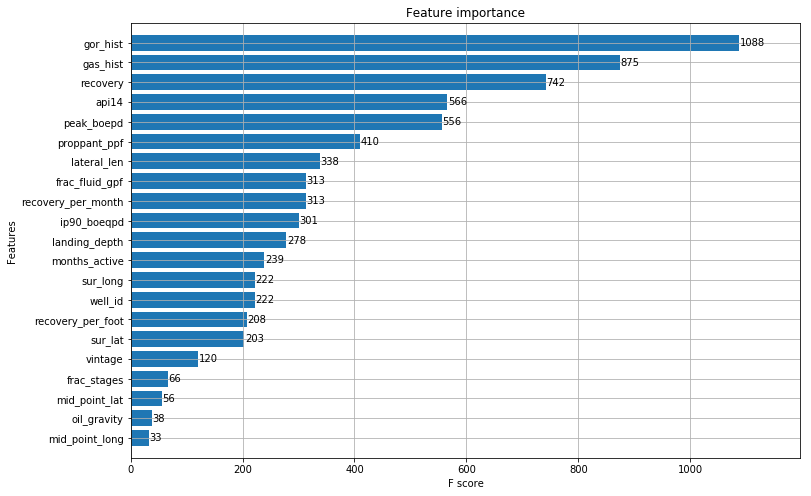

In [27]:
xgb_params = {
    'max_depth': 8,
    'seed' : 493
}
dtrain = xgb.DMatrix(xgb_df, df.oil_hist, feature_names=xgb_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [ ]:
df1 = df.drop(columns=['mid_point_long', 'mid_point_lat',                                                                              ])

In [ ]:
# Plot the log error
plt.figure(figsize=(12,8))
plt.scatter(range(df.shape[0]), np.sort(df_features.logerror.values))
plt.xlabel(df_features.index) # I made parcelid the index
plt.ylabel('logerror')
plt.show()

### Pairwise Scatterplots of Attributes